# Prelude

In [33]:
# Utilities
import numpy as np
import pathlib

# ML libraries
import tensorflow as tf
from tensorflow.keras import layers

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

In [34]:
# Access dataset using paths
frames = pathlib.Path("./frames")

train_frames = frames / "train"
train_norm_frames = train_frames / "norm"
train_weap_frames = train_frames / "weap"

test_frames = frames / "test"
test_norm_frames = test_frames / "norm"
test_weap_frames = test_frames / "weap"

In [35]:
# Basic dataset statistics
print("Number of training frames: {}".format(len(list(train_frames.glob("**/*.png")))))
print("Training frames statistics:")
print("\tNumber of normal frames: {}".format(len(list(train_norm_frames.glob("**/*.png")))))
print("\tNumber of weapon frames: {}".format(len(list(train_weap_frames.glob("**/*.png")))))
print()
print("Number of testing frames: {}".format(len(list(test_frames.glob("**/*.png")))))
print("Testing frames statistics:")
print("\tNumber of normal frames: {}".format(len(list(test_norm_frames.glob("**/*.png")))))
print("\tNumber of weapon frames: {}".format(len(list(test_weap_frames.glob("**/*.png")))))

Number of training frames: 1130
Training frames statistics:
	Number of normal frames: 673
	Number of weapon frames: 457

Number of testing frames: 681
Testing frames statistics:
	Number of normal frames: 300
	Number of weapon frames: 381


# Loading dataset

In [36]:
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_frames,
    validation_split=0.2,
    subset="both",
    seed=123,
    batch_size=batch_size
)

Found 1130 files belonging to 2 classes.
Using 904 files for training.
Using 226 files for validation.


In [37]:
# Verify class names
class_names = train_ds.class_names
print(class_names)

['norm', 'weap']


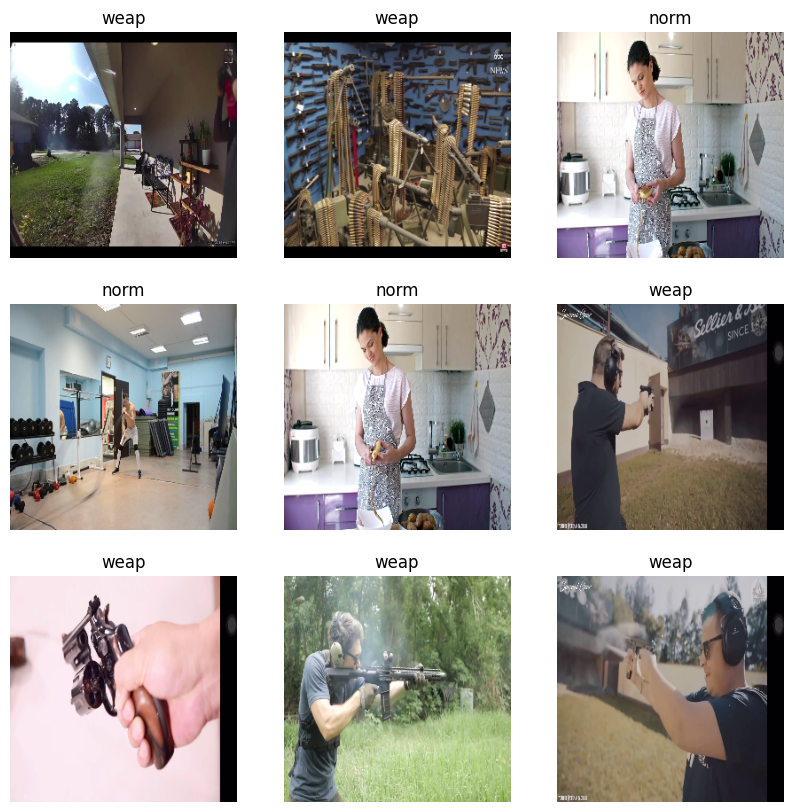

In [38]:
# Sanity check for label correctness
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [39]:
# Each training batch has 32 images, each of size 256 x 256 x 3
# Each label batch has 32 values, each corresponding to the labels of the images in the training batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Defining the model

In [41]:
# Basic Keras model
IMG_SIZE = 180
num_classes = len(class_names)

model = tf.keras.Sequential([
    # Preprocessing layers
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    
    # Convolution layers
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Additional Convolution Layers
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [42]:
# Compile model
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

model.build((None, IMG_SIZE, IMG_SIZE, 3))

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 lambda (Lambda)             (None, 180, 180, 1)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 180, 180, 1)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 180, 180, 1)       0         
 otation)                                                        
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 1)       0         
                                                      

# Training the model

In [62]:
epochs=400

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/400


29/29 [==============================] - 10s 352ms/step - loss: 0.0663 - accuracy: 0.9834 - val_loss: 0.0575 - val_accuracy: 0.9867
Epoch 2/400
29/29 [==============================] - 11s 365ms/step - loss: 0.0692 - accuracy: 0.9768 - val_loss: 0.0851 - val_accuracy: 0.9690
Epoch 3/400
29/29 [==============================] - 11s 367ms/step - loss: 0.0379 - accuracy: 0.9867 - val_loss: 0.0901 - val_accuracy: 0.9779
Epoch 4/400
29/29 [==============================] - 10s 361ms/step - loss: 0.0566 - accuracy: 0.9845 - val_loss: 0.0604 - val_accuracy: 0.9823
Epoch 5/400
29/29 [==============================] - 11s 365ms/step - loss: 0.0529 - accuracy: 0.9878 - val_loss: 0.0467 - val_accuracy: 0.9779
Epoch 6/400
29/29 [==============================] - 10s 354ms/step - loss: 0.0496 - accuracy: 0.9845 - val_loss: 0.1107 - val_accuracy: 0.9690
Epoch 7/400
29/29 [==============================] - 11s 364ms/step - loss: 0.0361 - accuracy: 0.9867 - val_loss: 0.0606 - val_accuracy: 0.9823
Epoc

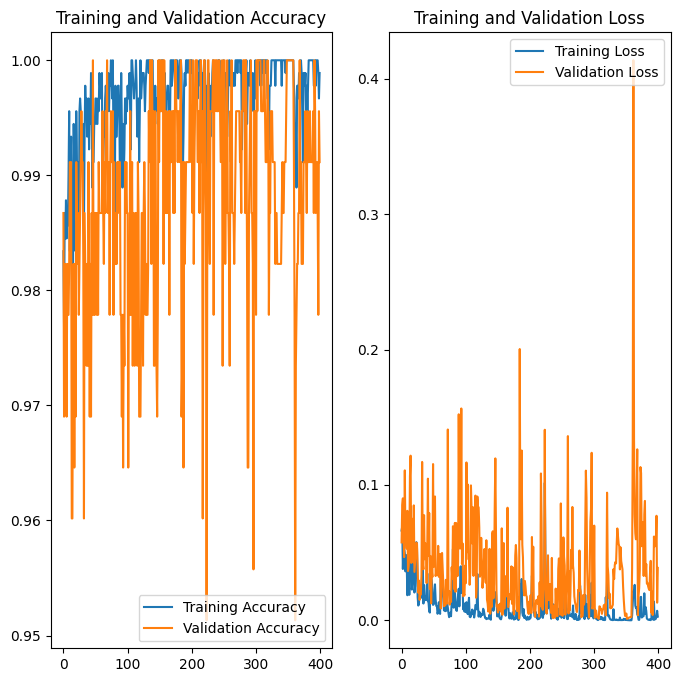

In [63]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = np.array(range(epochs))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model

In [68]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_frames, image_size=(IMG_SIZE, IMG_SIZE))

Found 681 files belonging to 2 classes.


In [69]:
loss, accuracy = model.evaluate(test_ds)

22/22 [==============================] - 3s 102ms/step - loss: 4.7194 - accuracy: 0.6740


In [66]:
predicted_labels = []
ground_labels = []

for image_batch, label_batch in test_ds:
  batch_predictions = model.predict(image_batch, verbose=0)
  scores = tf.nn.softmax(batch_predictions)
  predicted_labels += [np.argmax(score) for score in scores]
  ground_labels += [label for label in label_batch]

predicted_labels = np.array(predicted_labels)
ground_labels = np.array(ground_labels)

Text(0.5, 1.0, 'Confusion Matrix')

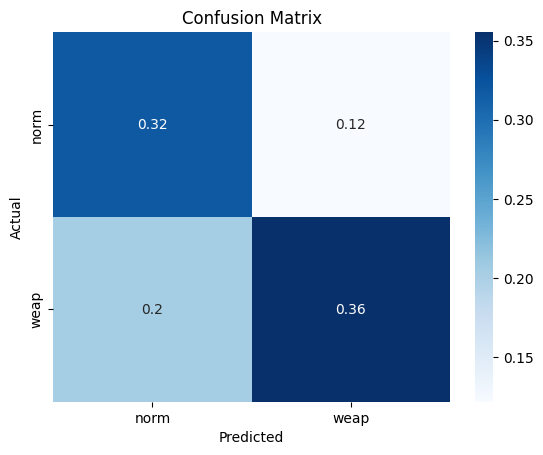

In [67]:
confusion_matrix = tf.math.confusion_matrix(ground_labels, predicted_labels, num_classes=num_classes)
sns.heatmap(confusion_matrix / np.sum(confusion_matrix), annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')